In [0]:
import tensorflow as tf 
import numpy as np
import matplotlib
from matplotlib import pyplot

from keras.models import Sequential
from keras.datasets.cifar10 import load_data
from keras.layers import Conv2D,Conv2DTranspose,Dense,ReLU,LeakyReLU,Flatten,Reshape,Dropout
from keras.optimizers import Adam

In [0]:
(x_train,y_train), (x_test,y_test) = load_data()


In [21]:
x_train.shape

(50000, 32, 32, 3)

In [0]:

def discriminator():
	model = Sequential()
	model.add(Conv2D(64,(3,3),padding='same',input_shape = (32,32,3)))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))
	
	model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))
	model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	#model.add(Dropout(0.4))

	
	model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))

	model.add(Dense(1,activation = 'sigmoid'))
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)

	model.compile(optimizer= optimus , loss = 'binary_crossentropy' , metrics= ['accuracy'])
	return model

In [0]:
def generator(laten_dim ):
	model = Sequential()
	model.add(Dense(4*4*256 ,input_dim = laten_dim))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Reshape((4,4,256)))
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	
	model.add(Conv2DTranspose(128, (4,4) , strides= (2,2), padding= 'same'))
	model.add(LeakyReLU(alpha = 0.2))
	
	model.add(Conv2D(3,(3,3),activation='tanh',padding = 'same'))

	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)

	model.compile(optimizer= optimus , loss = 'binary_crossentropy' )
	return model


In [0]:

def gan(g_model,d_model):
    
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)
	model.compile(optimizer = optimus,loss= 'binary_crossentropy'  )
	return model

In [0]:

def load_real_samples():

	(x_train,_),(_,_) = load_data()
	x_train  = x_train.astype('float32')

	x_train = (x_train-127.5)/127.5
	return x_train

In [0]:

def generate_real_samples(dataset , n_samples):

	for i in range (n_samples):
		index = np.random.randint(0 , dataset.shape[0] , n_samples)

		image = dataset[index]
		y = np.ones((n_samples,1))

		return image,y

In [0]:

def generate_latent_sample(laten_dim,n_samples):
	
	x = np.random.randn(laten_dim*n_samples)
	x = x.reshape(n_samples,laten_dim)

	return x

In [0]:

def generate_fake_samples(g_model, latent_dim,n_samples):
	
	x = generate_latent_sample(latent_dim,n_samples)
	x = g_model.predict(x)
	y = np.zeros((n_samples,1))

	return x,y

In [0]:
def save_plot(examples ,epoch , n = 7):
	examples = (examples+1) / 2.0

	for i in range(n*n):
		pyplot.subplot(n,n,1+i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%0.3d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [0]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples = 150):

	x_real ,y_real = generate_real_samples(dataset,n_samples)
	_,acc_real = d_model.evaluate(x_real,y_real)

	x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
	_,acc_fake = d_model.evaluate(x_fake,y_fake)

	print(('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)))
	save_plot(x_fake,epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)



In [0]:
def train(g_model,d_model,gan_model, dataset ,latent_dim, n_epoch = 130, n_batch = 128):
	batch_per_epoch = int(dataset.shape[0]/n_batch)
	batch = int(n_batch/2)

	for i in range(n_epoch):
		for j in range (batch_per_epoch):

			x_real,y_real = generate_real_samples(dataset,batch)

			d_model_loss1,_ = d_model.train_on_batch(x_real,y_real)

			x_fake ,y_fake = generate_fake_samples(g_model,latent_dim,batch)

			d_model_loss2,_ =d_model.train_on_batch(x_fake,y_fake)

			x_gan = generate_latent_sample(latent_dim, n_batch)
			y_gan = np.ones((n_batch,1))

			g_model_loss = gan_model.train_on_batch(x_gan,y_gan)

			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f'% 
                  (i+1, j+1, batch_per_epoch, d_model_loss1, d_model_loss2, g_model_loss))
		if (i+1) % 10 ==0 :
			summarize_performance(i,g_model,d_model,dataset,latent_dim)


In [33]:

latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model,d_model)

d_model.summary()
g_model.summary()
dataset = load_real_samples()

train(g_model,d_model,gan_model,dataset,latent_dim)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 256)       

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>118, 78/390, d1=0.638, d2=0.582 g=1.048
>118, 79/390, d1=0.685, d2=0.554 g=0.986
>118, 80/390, d1=0.667, d2=0.622 g=0.953
>118, 81/390, d1=0.590, d2=0.591 g=0.971
>118, 82/390, d1=0.608, d2=0.568 g=0.944
>118, 83/390, d1=0.554, d2=0.582 g=0.937
>118, 84/390, d1=0.678, d2=0.618 g=0.961
>118, 85/390, d1=0.538, d2=0.553 g=1.082
>118, 86/390, d1=0.572, d2=0.524 g=1.030
>118, 87/390, d1=0.605, d2=0.640 g=0.999
>118, 88/390, d1=0.676, d2=0.573 g=1.059
>118, 89/390, d1=0.613, d2=0.547 g=1.034
>118, 90/390, d1=0.598, d2=0.512 g=1.026
>118, 91/390, d1=0.555, d2=0.627 g=1.025
>118, 92/390, d1=0.720, d2=0.648 g=0.977
>118, 93/390, d1=0.531, d2=0.633 g=1.015
>118, 94/390, d1=0.627, d2=0.568 g=1.036
>118, 95/390, d1=0.629, d2=0.572 g=1.077
>118, 96/390, d1=0.574, d2=0.564 g=1.041
>118, 97/390, d1=0.667, d2=0.549 g=1.055
>118, 98/390, d1=0.597, d2=0.598 g=1.022
>118, 99/390, d1=0.574, d2=0.603 g=1.117
>118, 100/390, d1=0.651, d2=0.556 g=1.039
>118,

lesson learnt
1. train_on_batch on d_model gives 2 argument


Generated Image


<function matplotlib.pyplot.show>

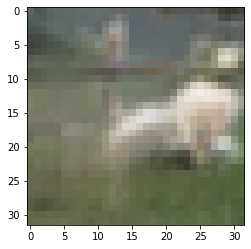

In [61]:
# a sample image

from keras.models import load_model

model = load_model('generator_model_110.h5')
vector = np.asarray([[0.6 for _ in range(100)]])

x= model.predict(vector)
x = (x+1)/2
print("Generated Image")
pyplot.imshow(x[0,:,:])
pyplot.show

Real Image


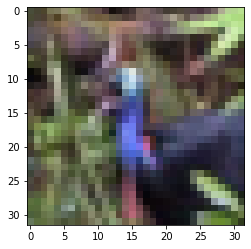

In [55]:
print("Real Image")
pyplot.imshow(x_train[24])